# Centroid alignment using Xopt/BAX

# Imports

In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import sys
import matplotlib.pyplot as plt
import os    

import pandas as pd
import torch

from xopt import Xopt
from xopt.vocs import VOCS
from xopt.generators.bayesian.bax_generator import BaxGenerator
from xopt.generators.bayesian.expected_improvement import ExpectedImprovementGenerator

from xopt.evaluator import Evaluator

import time
import numpy as np
import random

# Pathwise sampling for Linear Product Kernel

In [2]:
import copy
import math

def draw_poly_kernel_prior_paths(
    poly_kernel, n_samples
):  # poly_kernel is a scaled polynomial kernel
    c = poly_kernel.offset
    degree = poly_kernel.power
    ws = torch.randn(size=[n_samples, 1, degree + 1], device=c.device)

    def paths(xs):
        if (
            len(xs.shape) == 2 and xs.shape[1] == 1
        ):  # xs must be n_samples x npoints x 1 dim
            xs = xs.repeat(n_samples, 1, 1)  # duplicate over batch (sample) dim

        coeffs = [math.comb(degree, i) for i in range(degree + 1)]
        X = torch.concat(
            [
                (coeff * c.pow(i)).sqrt() * xs.pow(degree - i)
                for i, coeff in enumerate(coeffs)
            ],
            dim=2,
        )
        W = ws.repeat(1, xs.shape[1], 1)  # ws is n_samples x 1 x 3 dim

        phis = W * X
        return torch.sum(phis, dim=-1)  # result tensor is shape n_samples x npoints

    return paths

def draw_linear_product_kernel_prior_paths(model, n_samples):
    ndim = model.train_inputs[0].shape[1]

    outputscale = copy.copy(model.covar_module.outputscale.detach())
    kernels = []
    dims = []

    for i in range(len(model.covar_module.base_kernel.kernels)):
        lin_kernel = copy.deepcopy(model.covar_module.base_kernel.kernels[i])
        kernels += [lin_kernel]
        dims += [lin_kernel.active_dims]

    lin_prior_paths = [
        draw_poly_kernel_prior_paths(kernel, n_samples) for kernel in kernels
    ]

    def linear_product_kernel_prior_paths(xs):
        ys_lin = []
        for i in range(len(lin_prior_paths)):
            xs_lin = torch.index_select(xs, dim=-1, index=dims[i]).float()
            ys_lin += [lin_prior_paths[i](xs_lin)]
        output = 1.0
        for ys in ys_lin:
            output *= ys
        return (outputscale.sqrt() * output).double()

    return linear_product_kernel_prior_paths

def draw_linear_product_kernel_post_paths(model, n_samples, cpu=True):
    linear_product_kernel_prior_paths = draw_linear_product_kernel_prior_paths(
        model, n_samples=n_samples
    )

    train_x = model.train_inputs[0]

    train_y = model.train_targets.reshape(-1, 1)

    train_y = train_y - model.mean_module(train_x).reshape(train_y.shape)

    Knn = model.covar_module(train_x, train_x)

    sigma = torch.sqrt(model.likelihood.noise[0])

    K = Knn + sigma**2 * torch.eye(Knn.shape[0])

    prior_residual = train_y.repeat(n_samples, 1, 1).reshape(
        n_samples, -1
    ) - linear_product_kernel_prior_paths(train_x)
    prior_residual -= sigma * torch.randn_like(prior_residual)

    Lnn = torch.cholesky(K.to_dense())
    batched_lnn = torch.stack([Lnn] * n_samples)
    batched_lnnt = torch.stack([Lnn.T] * n_samples)

    vbar = torch.linalg.solve(batched_lnn, prior_residual)
    v = torch.linalg.solve(batched_lnnt, vbar)
    v = v.reshape(-1, 1)

    v = v.reshape(n_samples, -1, 1)
    v_t = v.transpose(1, 2)

    def post_paths(xs):
        if model.input_transform is not None:
            xs = model.input_transform(xs)

        K_update = model.covar_module(train_x, xs.double())

        update = torch.matmul(v_t, K_update)
        update = update.reshape(n_samples, -1)

        prior = linear_product_kernel_prior_paths(xs)

        post = prior + update + model.mean_module(xs)
        if model.outcome_transform is not None:
            post = model.outcome_transform.untransform(post)[0]

        return post

    post_paths.n_samples = n_samples

    return post_paths

# Alignment Algorithm

In [3]:
from xopt.generators.bayesian.bax.algorithms import Algorithm
from abc import ABC
from pydantic import Field
from scipy.optimize import minimize
from torch import Tensor
from botorch.models.model import Model, ModelList
from typing import Dict, Tuple, Union

def unif_random_sample_domain(n_samples, domain):
    ndim = len(domain)

    # uniform sample, rescaled, and shifted to cover the domain
    x_samples = torch.rand(n_samples, ndim) * torch.tensor(
        [bounds[1] - bounds[0] for bounds in domain]
    ) + torch.tensor([bounds[0] for bounds in domain])

    return x_samples

class ScipyBeamAlignment(Algorithm, ABC):
    name = "ScipyBeamAlignment"
    meas_dims: Union[int, list[int]] = Field(
        description="dimension indeces of the quads through which the beam will be aligned"
    )
    centroid_position_keys : list[str] = Field(
        description="names of centroid position outputs used to measure alignment")


    @property
    def model_names_ordered(self) -> list:  
        # get observable model names in the order they appear in the model (ModelList)
        return [name for name in self.centroid_position_keys]
    
    def get_execution_paths(
        self, model: Model, bounds: Tensor
    ) -> Tuple[Tensor, Tensor, Dict]:
        """get execution paths that minimize the objective function"""

        x_stars_all, xs, ys, post_paths_cpu = self.get_sample_optimal_tuning_configs(
            model.models[0], bounds, cpu=False
        )

        xs_exe = xs
        ys_exe = ys.reshape(*ys.shape, 1)

        results_dict = {
            "xs_exe": xs_exe,
            "ys_exe": ys_exe,
            "X_stars": x_stars_all,
            "post_paths_cpu": post_paths_cpu,
        }

        return xs_exe, ys_exe, results_dict

    def get_sample_optimal_tuning_configs(
        self, model: Model, bounds: Tensor, verbose=False, cpu=False
    ):
        meas_scans = torch.index_select(
            bounds.T, dim=0, index=torch.tensor(self.meas_dims)
        )
        ndim = bounds.shape[1]
        tuning_dims = [i for i in range(ndim) if i not in self.meas_dims]
        tuning_domain = torch.index_select(
            bounds.T, dim=0, index=torch.tensor(tuning_dims)
        )

        device = torch.tensor(1).device
        torch.set_default_tensor_type("torch.DoubleTensor")

        cpu_model = copy.deepcopy(model).cpu()

        post_paths_cpu = draw_linear_product_kernel_post_paths(
            cpu_model, n_samples=self.n_samples
        )

        xs_tuning_init = unif_random_sample_domain(
            self.n_samples, tuning_domain
        ).double()

        x_tuning_init = xs_tuning_init.flatten()

        # minimize
        def target_func_for_scipy(x_tuning_flat):
            return (
                self.sum_samplewise_misalignment_flat_x(
                    post_paths_cpu,
                    torch.tensor(x_tuning_flat),
                    self.meas_dims,
                    meas_scans.cpu(),
                )
                .detach()
                .cpu()
                .numpy()
            )

        def target_func_for_torch(x_tuning_flat):
            return self.sum_samplewise_misalignment_flat_x(
                post_paths_cpu, x_tuning_flat, self.meas_dims, meas_scans.cpu()
            )

        def target_jac(x):
            return (
                torch.autograd.functional.jacobian(
                    target_func_for_torch, torch.tensor(x)
                )
                .detach()
                .cpu()
                .numpy()
            )

        res = minimize(
            target_func_for_scipy,
            x_tuning_init.detach().cpu().numpy(),
            jac=target_jac,
            bounds=tuning_domain.repeat(self.n_samples, 1).detach().cpu().numpy(),
            options={"eps": 1e-03},
        )
        if verbose:
            print(
                "ScipyBeamAlignment evaluated",
                self.n_samples,
                "(pathwise) posterior samples",
                res.nfev,
                "times in get_sample_optimal_tuning_configs().",
            )

            print(
                "ScipyBeamAlignment evaluated",
                self.n_samples,
                "(pathwise) posterior sample jacobians",
                res.njev,
                "times in get_sample_optimal_tuning_configs().",
            )

            print(
                "ScipyBeamAlignment took",
                res.nit,
                "steps in get_sample_optimal_tuning_configs().",
            )

        x_stars_flat = torch.tensor(res.x)

        x_stars_all = x_stars_flat.reshape(
            self.n_samples, -1
        )  # each row represents its respective sample's optimal tuning config

        misalignment, xs, ys = self.post_path_misalignment(
            post_paths_cpu,
            x_stars_all,  # n x d tensor
            self.meas_dims,  # list of integers
            meas_scans.cpu(),  # tensor of measurement device(s) scan inputs, shape: len(meas_dims) x 2
            samplewise=True,
        )

        if device.type == "cuda":
            torch.set_default_tensor_type("torch.cuda.DoubleTensor")

        if cpu:
            return x_stars_all, xs, ys, post_paths_cpu  # x_stars should still be on cpu
        else:
            return x_stars_all.to(device), xs.to(device), ys.to(device), post_paths_cpu
        
    def post_path_misalignment(
        self,
        post_paths,
        x_tuning,  # n x d tensor
        meas_dims,  # list of integers
        meas_scans,  # tensor of measurement device(s) scan inputs, shape: len(meas_dims) x 2
        samplewise=False,
    ):
        """
        A function that computes the beam misalignment(s) through a set of measurement quadrupoles
        from a set of pathwise samples taken from a SingleTaskGP model of the beam centroid position with
        respect to some tuning devices and some measurement quadrupoles.

        arguments:
            post_paths: a pathwise posterior sample from a SingleTaskGP model of the beam centroid
                        position (assumes Linear ProductKernel)
            x_tuning: a tensor of shape (n_samples x n_tuning_dims) where the nth row defines a point in
                        tuning-parameter space at which to evaluate the misalignment of the nth
                        posterior pathwise sample given by post_paths
            meas_dims: the dimension indeces of our model that describe the quadrupole measurement devices
            meas_scans: a tensor of measurement scan inputs, shape len(meas_dims) x 2, where the nth row
                        contains two input scan values for the nth measurement quadrupole
            samplewise: boolean. Set to False if you want to evaluate the misalignment for every point on
                        every sample. If set to True, the misalignment for the nth sample (given by post_paths)
                        will only be evaluated at the nth point (given by x_tuning). If samplewise is set to
                        True, x_tuning must be shape n_samples x n_tuning_dims

         returns:
             misalignment: the sum of the squared slopes of the beam centroid model output with respect to the
                             measurement quads
             xs: the virtual scan inputs
             ys: the virtual scan outputs (beam centroid positions)

        NOTE: meas scans only needs to have 2 values for each device because it is expected that post_paths
                are produced from a SingleTaskGP with Linear ProductKernel (i.e. post_paths should have
                linear output for each dimension).
        """
        n_steps_meas_scan = 1 + len(meas_dims)
        n_tuning_configs = x_tuning.shape[0]

        # construct measurement scan inputs
        xs = torch.repeat_interleave(x_tuning, n_steps_meas_scan, dim=0)

        for i in range(len(meas_dims)):
            meas_dim = meas_dims[i]
            meas_scan = meas_scans[i]
            full_scan_column = meas_scan[0].repeat(n_steps_meas_scan, 1)
            full_scan_column[i + 1, 0] = meas_scan[1]
            full_scan_column_repeated = full_scan_column.repeat(n_tuning_configs, 1)

            xs = torch.cat(
                (xs[:, :meas_dim], full_scan_column_repeated, xs[:, meas_dim:]), dim=1
            )

        if samplewise:
            xs = xs.reshape(n_tuning_configs, n_steps_meas_scan, -1)

        ys = post_paths(xs)
        ys = ys.reshape(-1, n_steps_meas_scan)

        rise = ys[:, 1:] - ys[:, 0].reshape(-1, 1)
        run = (meas_scans[:, 1] - meas_scans[:, 0]).T.repeat(ys.shape[0], 1)
        slope = rise / run

        misalignment = slope.pow(2).sum(dim=1)

        if not samplewise:
            ys = ys.reshape(-1, n_tuning_configs, n_steps_meas_scan)
            misalignment = misalignment.reshape(-1, n_tuning_configs)

        return misalignment, xs, ys
    
    def sum_samplewise_misalignment_flat_x(
        self, post_paths, x_tuning_flat, meas_dims, meas_scans
    ):
        """
        A wrapper function that computes the sum of the samplewise misalignments for more convenient
        minimization with scipy.

        arguments:
            Same as post_path_misalignment() EXCEPT:

            x_tuning_flat: a FLATTENED tensor formerly of shape (n_samples x ndim) where the nth
                            row defines a point in tuning-parameter space at which to evaluate the
                            misalignment of the nth posterior pathwise sample given by post_paths

            NOTE: x_tuning_flat must be 1d (flattened) so the output of this function can be minimized
                    with scipy minimization routines (that expect a 1d vector of inputs)
            NOTE: samplewise is set to True to avoid unncessary computation during simultaneous minimization
                    of the pathwise misalignments.
        """

        x_tuning = x_tuning_flat.double().reshape(post_paths.n_samples, -1)

        return torch.sum(
            self.post_path_misalignment(
                post_paths, x_tuning, meas_dims, meas_scans, samplewise=True
            )[0]
        )

# Notebook settings

In [4]:
noise = False #whether to add noise to the ground-truth beam size function outputs
n_obs_init = 3 #number of random initial observations for GP model
n_samples = 10 #number of posterior samples for BAX
rand_seed = 0

#random seeds for reproducibility 
torch.manual_seed(rand_seed)
np.random.seed(rand_seed) #only affects initial random observations through Xopt
random.seed(rand_seed)

# Build test function from single-quadrupole optical beam size model 
Here we define a simple ground-truth beam size function for our optimization problem, where we attempt to find the location in tuning parameter space with minimal emittance. Note that the function "test_func" used to evaluate the ground-truth beam size function takes a dictionary as input and returns a dictionary as the output.

setting camera DYG14


CA.Client.Exception...............................................
    Context: "Channel: "13ARV1:image1:ArrayData", Connecting to: 146.139.52.185:5064, Ignored: awa5:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Thu Jan 18 2024 12:09:55.558741672
..................................................................
CA.Client.Exception...............................................
    Context: "Channel: "13ARV1:image1:ArraySize0_RBV", Connecting to: 146.139.52.185:5064, Ignored: awa5:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Thu Jan 18 2024 12:09:55.559568293
..................................................................
CA.Client.Exception...............................................
    Context: "Channel: "13ARV1:image1:ArraySize1_RBV", Connecting to: 146.139.52.185:5064, Ignored: awa5:5064"
    Source File: ../cac.cpp line 1320
    Current Time: Thu Jan 18 2024 12:09:55.559731331
................................................................

192.168.2.111
ip address already set
starting acquisition
please shutter beam


please un-shutter beam


background file: /home/awa/awa_data/01-18_6DReconstruction/DYG14_background.npy
displaying image
fitting image


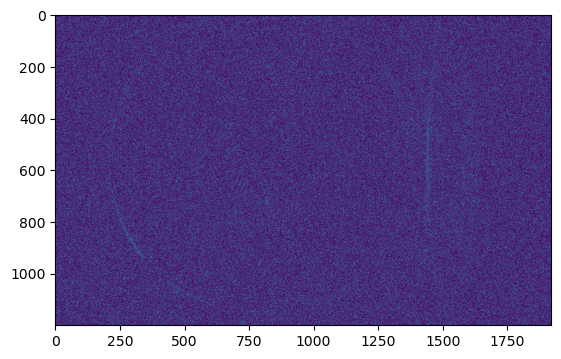

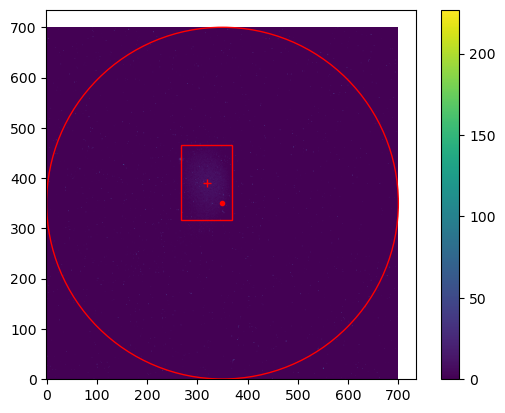

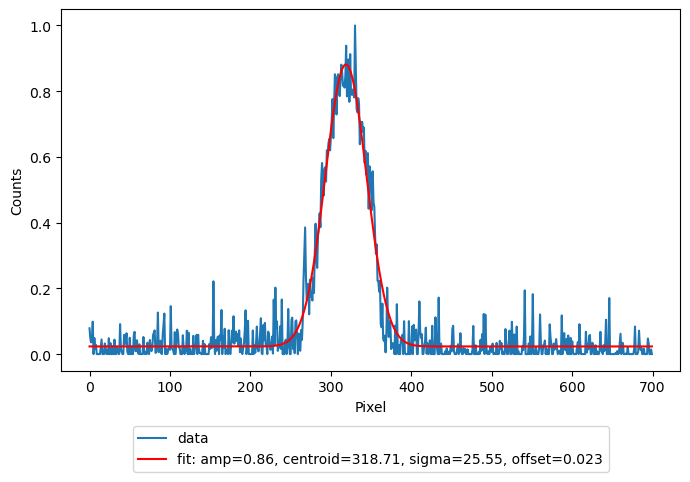

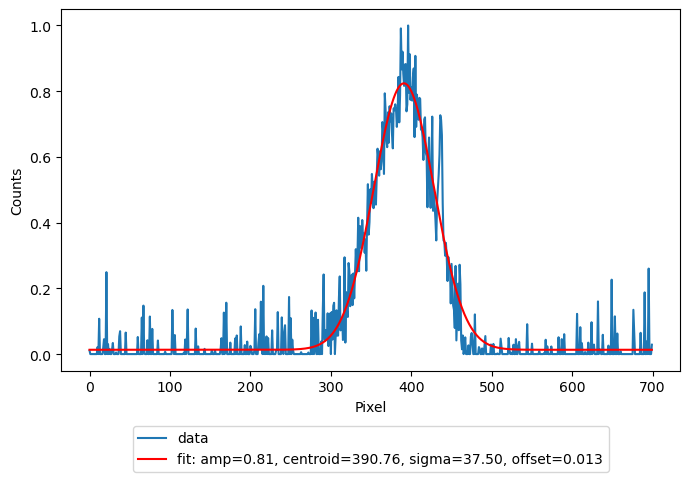

In [5]:
import sys
sys.path.append('../control_notebooks')
from measurement import get_DYG14, set_camera, set_background

save_image_location = "/home/awa/awa_data/01-18_6DReconstruction/"
image_diagnostic = get_DYG14()
image_diagnostic.save_image_location = save_image_location
image_diagnostic.target_charge = None
image_diagnostic.threshold = 20.0
image_diagnostic.min_log_intensity = 0.0
image_diagnostic.bounding_box_half_width = 2.0

set_background(image_diagnostic)

from epics import caput, caget
from xopt import Evaluator
import time
import numpy as np

IMAGE_CONSTRAINTS = {
            "bb_penalty": ["LESS_THAN", 0.0],
            "log10_total_intensity": ["GREATER_THAN", image_diagnostic.min_log_intensity]
        }
image_diagnostic.visualize = False


In [6]:
def evaluate_function(inputs: dict) -> dict:
    global image_diagnostic
    correct_inputs = {"x0":'AWA:EEXBL:ET12H_B_N:Ctrl',
                      "x1":'AWA:Bira4Ctrl:Ch10'}
    # caput values
    for name, val in inputs.items():
        caput(correct_inputs[name], val)

    # wait for changes to occur - use small wait time for interpolated measurements
    time.sleep(1)

    results = image_diagnostic.measure_beamsize(1, **inputs)

    # add total beam size
    sigma_xy = np.sqrt(np.array(results["Sx"])**2 + np.array(results["Sy"])**2)
    roundness = np.abs(np.array(results["Sx"]) - np.array(results["Sy"]))
    results["total_size"] = sigma_xy + roundness
    print(results["total_size"], results["bb_penalty"])
    results["y"] = results["Cx"]
    return results

evaluator = Evaluator(function=evaluate_function)

# Construct vocs

In [7]:

#construct vocs
vocs = VOCS(
    variables = {
        "x0":[-2.25,-1.75], # 'AWA:Drive:DT9H_B_N'
        "x1":[-0.6,0.25] # 'AWA:Bira4Ctrl:Ch10'
    },
    objectives = {"y":"MINIMIZE"},
    constraints = IMAGE_CONSTRAINTS,
    #constants = {"x0":0.0}
)

print('variable_names =', vocs.variable_names)
print('domain =\n', vocs.bounds.T)

variable_names = ['x0', 'x1']
domain =
 [[-2.25 -1.75]
 [-0.6   0.25]]


# Prepare generator.
In this example, we use a specialty covariance module (Linear ProductKernel) for our beam size model.

In [8]:
from gpytorch.kernels import MaternKernel, PolynomialKernel, ScaleKernel
from xopt.generators.bayesian.models.standard import StandardModelConstructor
from gpytorch.priors.torch_priors import GammaPrior
from xopt.generators.bayesian.bax_generator import BaxGenerator

# from emitopt.algorithms import ScipyBeamAlignment

# prepare custom covariance module
# covar_module = PolynomialKernel(power=1)
covar_module = PolynomialKernel(power=1, active_dims=[0]) * PolynomialKernel(power=1, active_dims=[1])
scaled_covar_module = ScaleKernel(covar_module)   
    
# prepare options for Xopt generator
covar_module_dict = {'y': scaled_covar_module}
# covar_module_dict = {}
model_constructor = StandardModelConstructor(covar_modules=covar_module_dict, use_low_noise_prior=True)

algo = ScipyBeamAlignment(meas_dims=[1], n_samples=50, centroid_position_keys=['y'])

# Construct generator, evaluator, Xopt objects

In [9]:
#construct BAX generator
generator = BaxGenerator(
    vocs=vocs, 
    gp_constructor=model_constructor, 
    algorithm=algo,
    n_interpolate_points=5,
)
# generator = ExpectedImprovementGenerator(vocs, generator_options)

#construct Xopt optimizer
optimizer = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

In [10]:
optimizer.random_evaluate(10)

fitting image
224.12667220392763 -97.4416392843161
fitting image
149.12836744086528 -137.11184581212567
fitting image
nan 612.470913797554
fitting image
261.28354282996764 -69.79980579942776
fitting image
92.06947353303528 -163.719040280971
fitting image
90.59531759728023 -187.52914151609428
fitting image
178.16414592529082 -81.76932987659018
fitting image
280.97234766656084 -32.39541419138669
fitting image
259.20272732243944 -50.20263459459676
fitting image
308.9023722202711 -28.749281358117514


,x0,x1,Cx,Cy,Sx,Sy,bb_penalty,total_intensity,log10_total_intensity,AWAVXI11ICT:Ch4,save_filename,total_size,y,xopt_runtime,xopt_error
0,-2.024407,-0.422966,306.705255,356.791828,12.767805,118.103168,-97.441639,2280109.2,6.357956,1.348832e-09,/home/awa/awa_data/01-18_6DReconstruction/DYG1...,224.126672,306.705255,2.396974,False
1,-2.107595,-0.199561,301.694630,361.373327,28.819724,86.640285,-137.111846,663199.0,5.821644,8.598172e-10,/home/awa/awa_data/01-18_6DReconstruction/DYG1...,149.128367,301.694630,2.253431,False
2,-2.051382,-0.232838,NaN,NaN,NaN,NaN,612.470914,43286.2,4.636349,3.270808e-10,/home/awa/awa_data/01-18_6DReconstruction/DYG1...,NaN,NaN,2.282364,False
3,-2.022442,-0.536757,311.788786,346.373420,9.663467,135.301179,-69.799806,1913571.6,6.281845,1.135485e-09,/home/awa/awa_data/01-18_6DReconstruction/DYG1...,261.283543,311.788786,2.365050,False
4,-1.961827,0.189619,381.811849,377.430592,60.030293,40.218366,-163.719040,539584.0,5.732059,8.589706e-10,/home/awa/awa_data/01-18_6DReconstruction/DYG1...,92.069474,381.811849,2.218974,False
5,-2.072947,0.175940,351.244300,379.266793,59.239691,40.282493,-187.529142,464250.2,5.666752,6.921449e-10,/home/awa/awa_data/01-18_6DReconstruction/DYG1...,90.595318,351.244300,2.299826,False
6,-1.968794,0.232814,310.304590,389.215471,103.236701,33.657189,-81.769330,2035580.4,6.308688,1.564732e-09,/home/awa/awa_data/01-18_6DReconstruction/DYG1...,178.164146,310.304590,2.344917,False
7,-2.195887,-0.457727,271.613789,363.978240,8.335465,144.533827,-32.395414,1426110.8,6.154153,7.772185e-10,/home/awa/awa_data/01-18_6DReconstruction/DYG1...,280.972348,271.613789,2.347968,False
8,-2.231831,-0.411433,266.454344,341.481307,12.387814,135.512753,-50.202635,914072.2,5.960981,7.496531e-10,/home/awa/awa_data/01-18_6DReconstruction/DYG1...,259.202727,266.454344,2.357421,False
9,-1.941721,-0.489510,327.523973,354.294667,6.265216,157.521521,-28.749281,1264336.4,6.101863,7.504240e-10,/home/awa/awa_data/01-18_6DReconstruction/DYG1...,308.902372,327.523973,2.376307,False


<Axes: xlabel='x1', ylabel='Cx'>

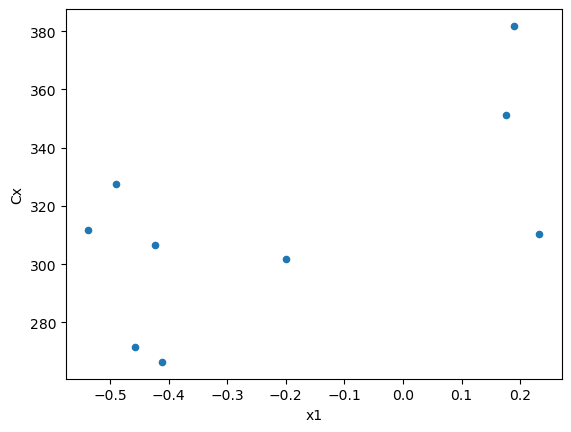

In [11]:
optimizer.data.plot.scatter(x="x1",y="Cx")

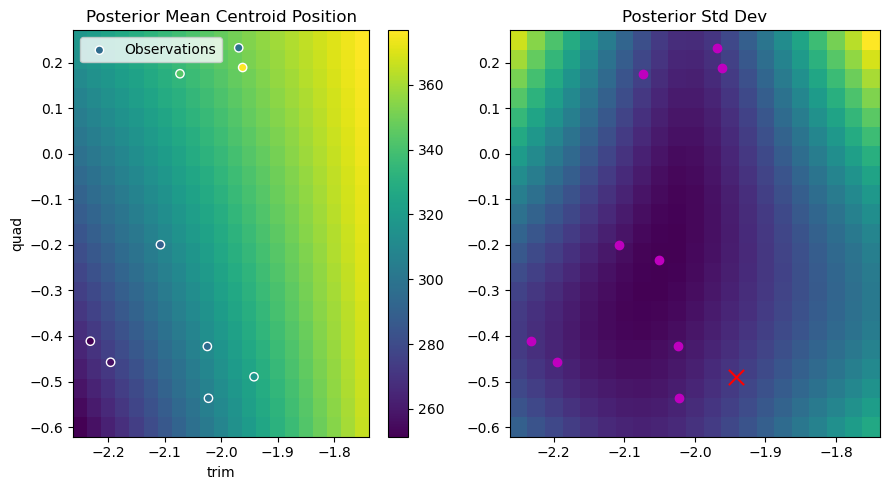

In [12]:
beam_centroid_model = optimizer.generator.train_model().models[0]

lsx = torch.linspace(*optimizer.vocs.bounds.T[0],21)
lsy = torch.linspace(*optimizer.vocs.bounds.T[1],21)

x0, x1 = torch.meshgrid(lsx, lsy)
xmesh_serialized = torch.cat((x0.reshape(-1,1), x1.reshape(-1,1)), dim=1)
ymesh_model = beam_centroid_model.posterior(xmesh_serialized).mean.reshape(21,21).detach()
ymesh_model_var = beam_centroid_model.posterior(xmesh_serialized).variance.reshape(21,21).detach()
#ymesh_gt = centroid_position_at_screen(xmesh_serialized).reshape(21,21).detach()

x0 = x0.numpy()
x1 = x1.numpy()

fig, axs = plt.subplots(1,2)
fig.set_size_inches(9,5)

ax = axs[0]
c = ax.pcolormesh(x0, x1, ymesh_model.numpy())
ax.set_xlabel('trim')
ax.set_ylabel('quad')
ax.set_title('Posterior Mean Centroid Position')
ax.scatter(optimizer.data['x0'], optimizer.data['x1'], c=optimizer.data['y'],
           edgecolors='w', label='Observations')
ax.legend()

ax = axs[1]
ax.pcolormesh(x0, x1, ymesh_model_var.sqrt().numpy())
fig.colorbar(c)

# for x_star in X_stars:
#     ax.axvline(float(x_star), ymax=0.1, c='r')
    
ax.scatter(optimizer.data['x0'][:-1], optimizer.data['x1'][:-1], c='m', label='Observations')
ax.scatter(optimizer.data['x0'][-1:], optimizer.data['x1'][-1:], c='r', marker='x', s=120)
ax.set_title('Posterior Std Dev')

plt.tight_layout()



Iteration 0 

fitting image
103.76417786387424 -133.6407104281684
fitting image
96.74077350908183 -90.01026098545321
fitting image
92.1186362382032 -135.73220114708587
fitting image
nan 6.3166300096984855
fitting image
81.6325987860569 -152.1534791613587


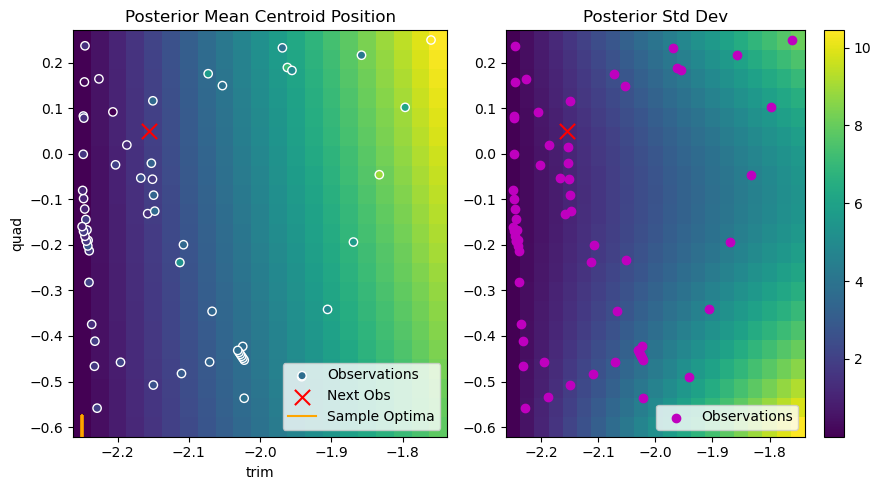

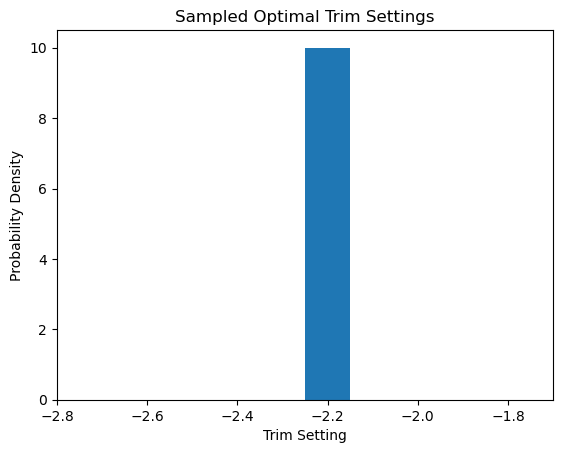



Iteration 1 

fitting image
87.85023558834402 -120.28485041397147
fitting image
83.71776990655648 -137.9293690441603
fitting image
99.64000030157914 -112.27995390808604
fitting image
91.48988736868205 -161.70000557158482
fitting image
99.07592736010157 -153.6695181982339


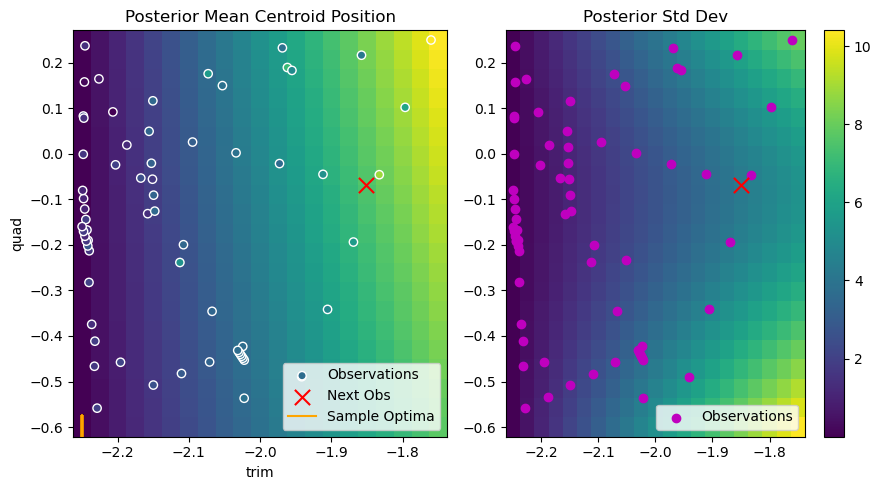

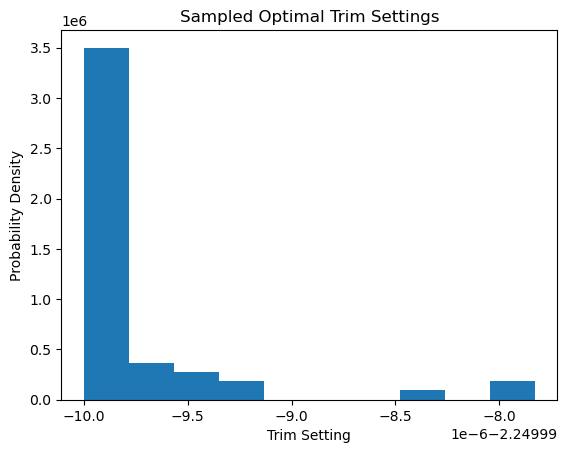



Iteration 2 

fitting image
104.45236371165501 -151.42361221908072
fitting image
110.89415497959766 -160.50263556328068
fitting image
108.87636068031719 -98.62438504709459
fitting image
118.08656887765089 -163.7574924954007
fitting image
93.07162306642758 -101.7827898232907


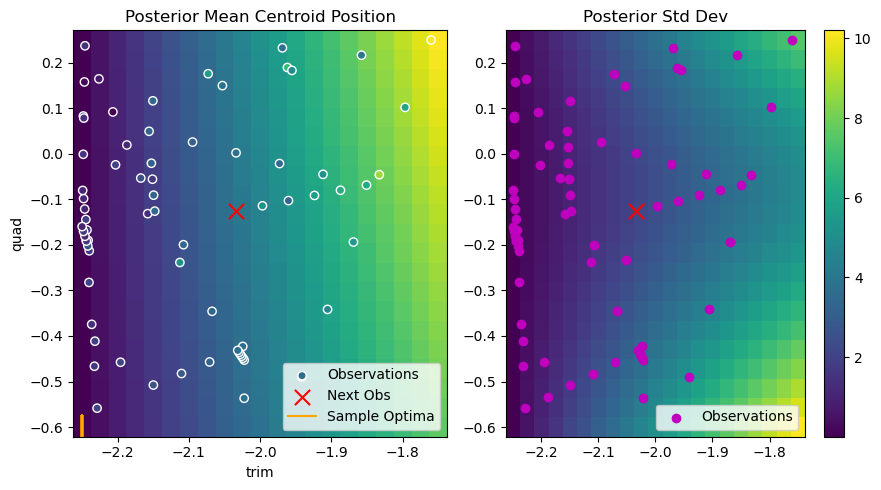

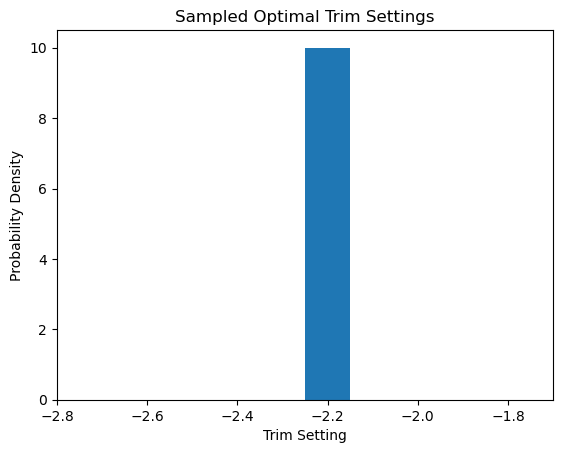



Iteration 3 

fitting image
97.2610656594179 -107.50983223915978
fitting image
83.14430969514348 -152.89211594067768
fitting image
90.60973994461597 -150.08927669302983
fitting image
157.08650201524352 -89.18800379701412
fitting image
176.3845185881571 -77.7024028294947


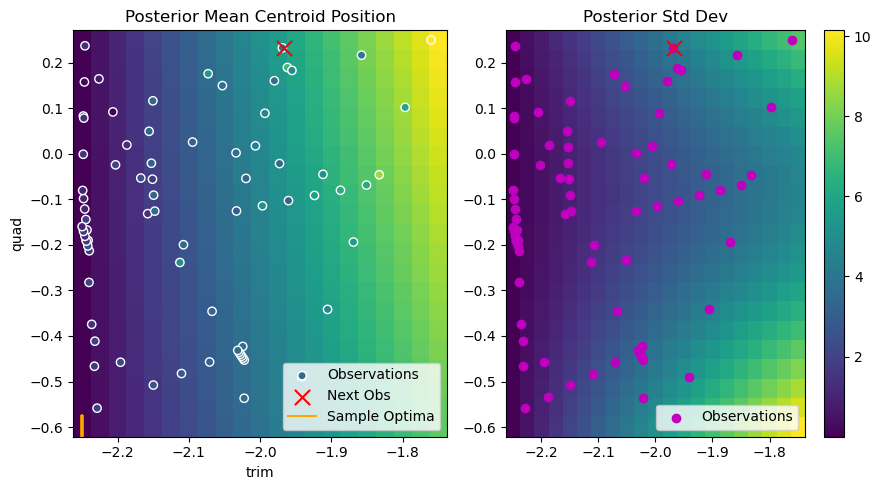

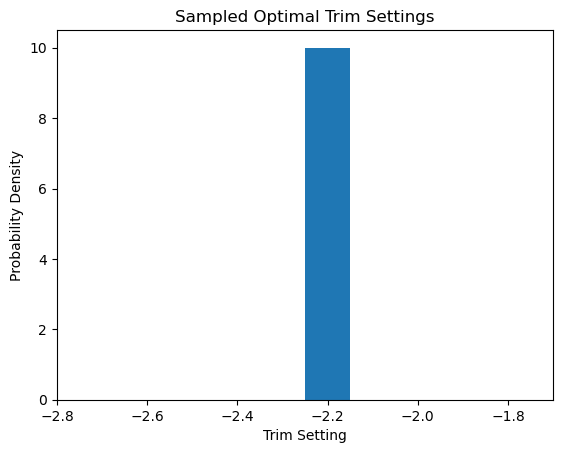



Iteration 4 

fitting image
98.15849528107378 -163.1706968545833
fitting image
123.47538498030138 -122.3870288740994
fitting image
80.70552875014837 -167.8755668115167
fitting image
135.14178233413548 -95.67319997916238
fitting image
116.51092882051486 -104.91078123991252


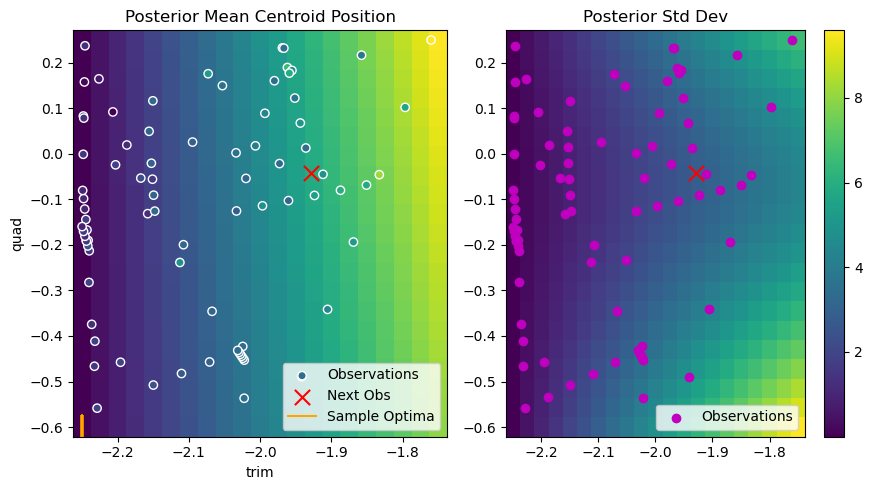

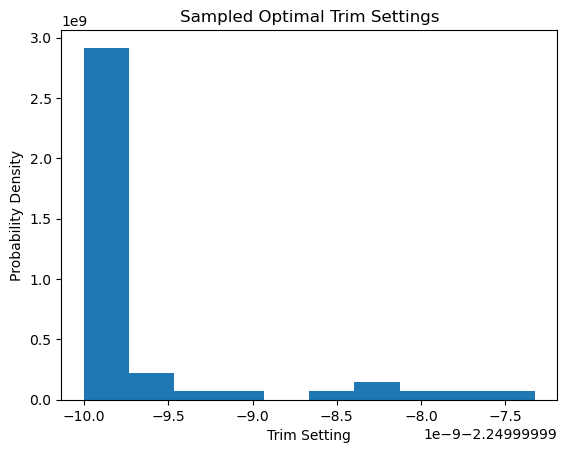



Iteration 5 

fitting image
88.66654827783915 -102.5886852654018
fitting image
97.06125984626479 -110.06523251582419
fitting image
98.27288991720678 -91.75685671241729
fitting image
94.0370607120226 -88.08540708908708
fitting image
124.85731194239779 -97.74407801209844


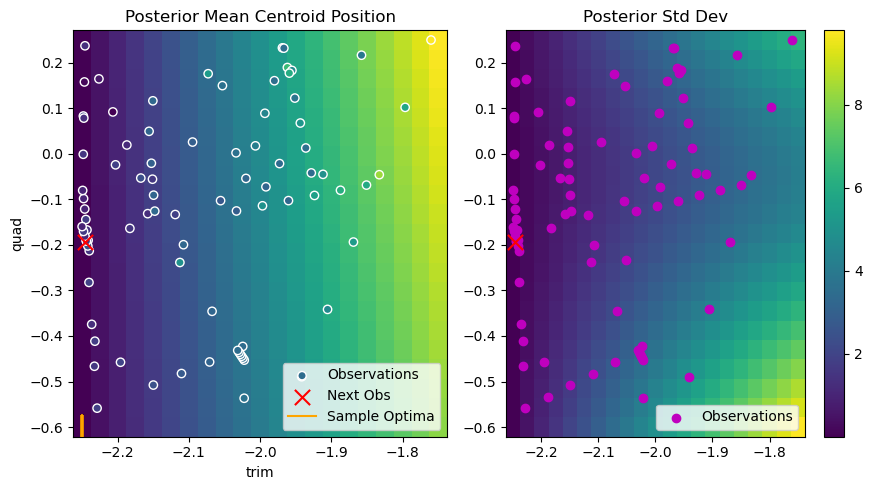

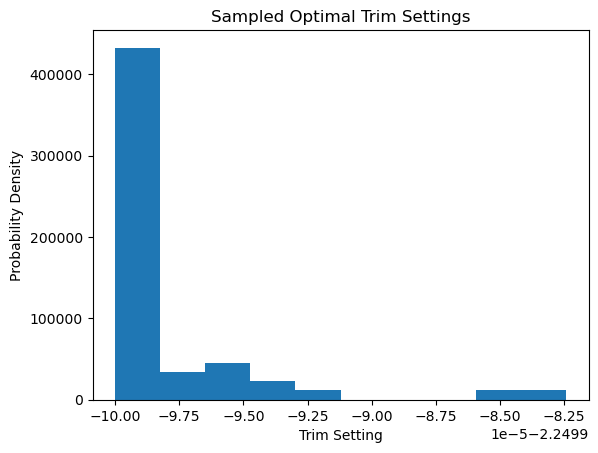



Iteration 6 

fitting image
115.01802480508596 -94.5242476177877
fitting image
90.21205609834107 -79.77675735849039
fitting image
96.6840605677587 -102.45089974870655
fitting image
93.86605423070054 -97.54433767069628
fitting image
112.78301527425774 -51.65280753248214


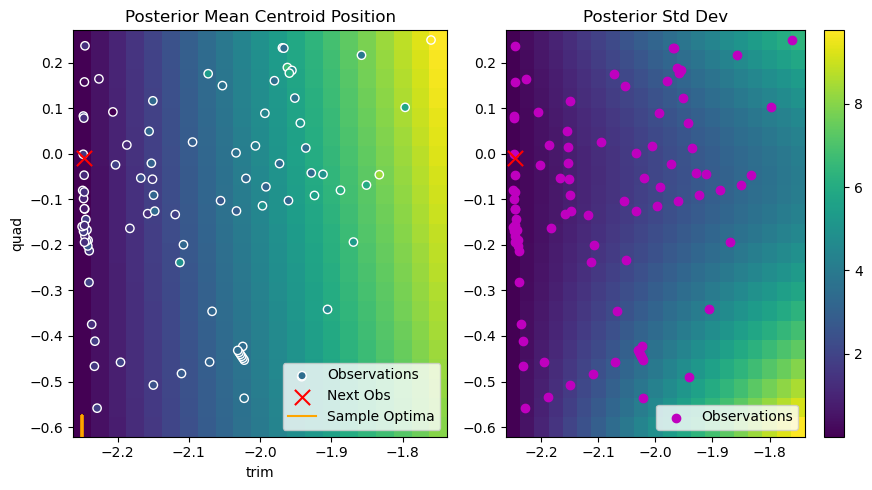

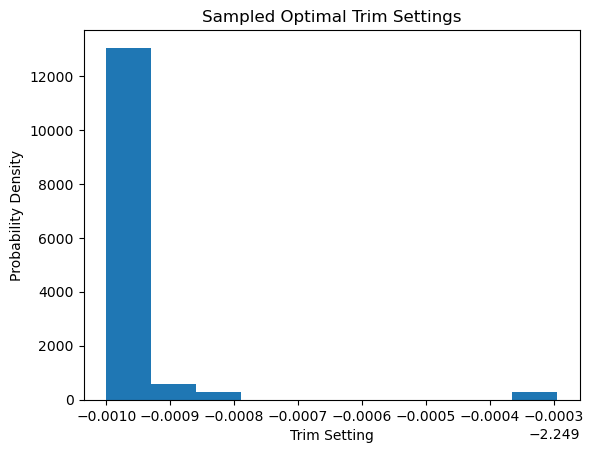



Iteration 7 

fitting image
153.4885309165931 -0.09768459418546627
fitting image
90.89346408747393 -117.88636532174655
fitting image
90.5624041901267 -115.85782645671227
fitting image
90.440548263037 -98.05888398032735
fitting image
99.91298403214978 -115.89099775070048


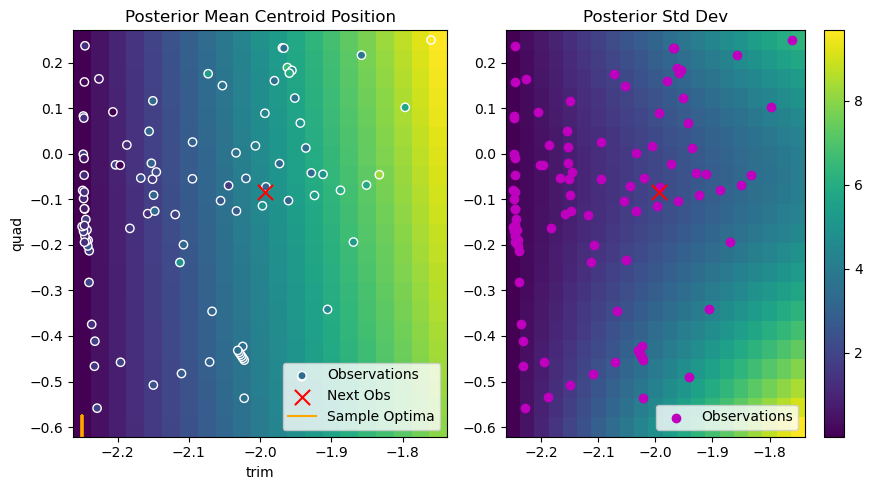

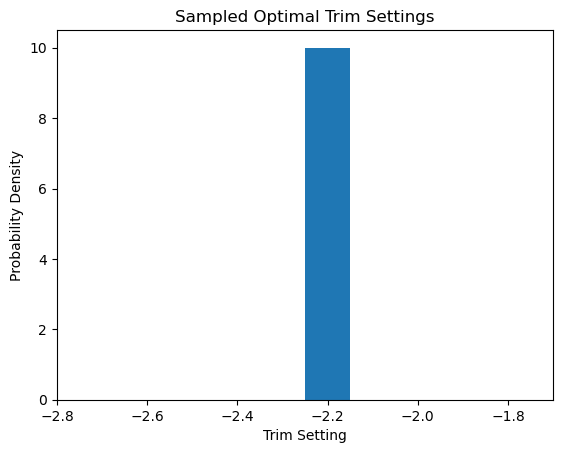



Iteration 8 

fitting image
108.79248417121607 -169.2579429757243
fitting image
118.11755605373668 -161.0393048160791
fitting image
98.56455600242802 -82.5666169787421
fitting image
113.46614913628801 -121.23836138575825
fitting image
95.50605447295169 -119.4944194540212


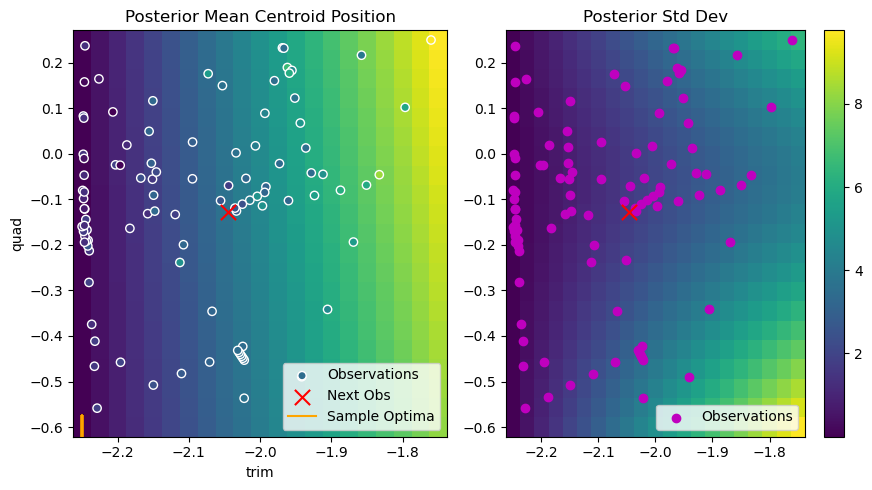

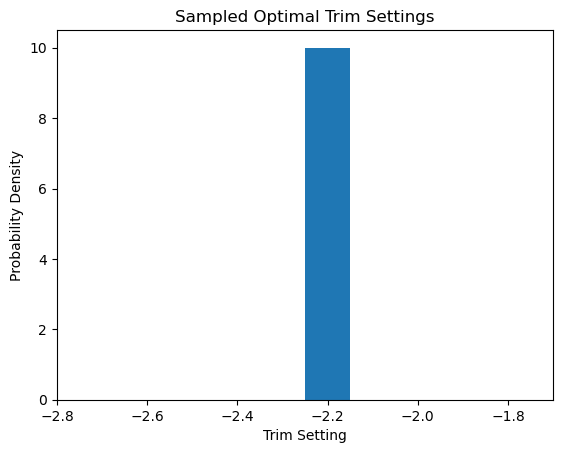



Iteration 9 

fitting image
97.78741584141119 -113.96573225613477
fitting image
114.2264427876919 -144.85343127040514
fitting image
95.2952314500265 -113.63738700964049
fitting image
103.69855414266101 -123.38958494327736
fitting image
105.7909459935693 -81.50581119690543


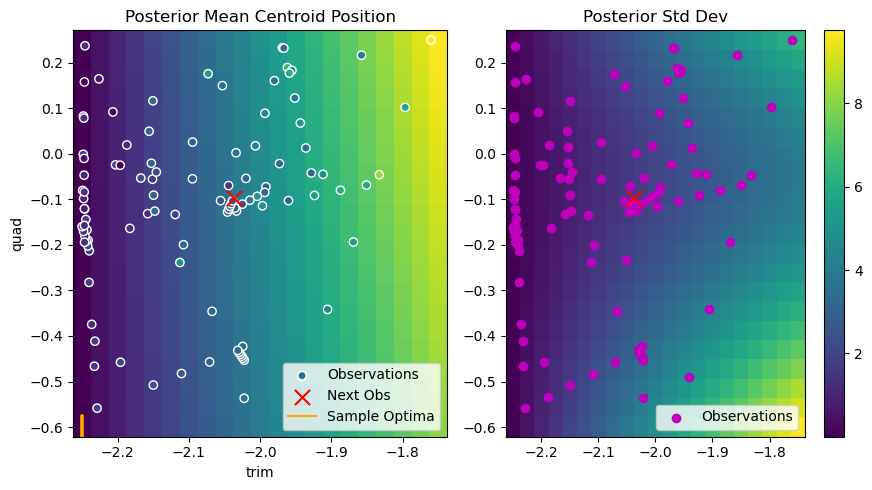

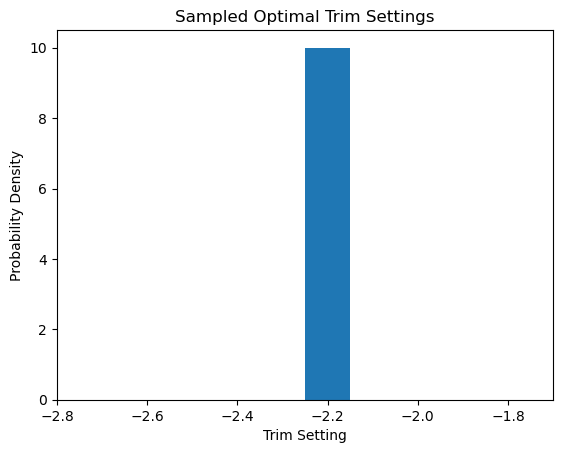

In [18]:
for i in range(10):
    print('\n\nIteration', i, '\n')
    optimizer.step()
#     X_stars = optimizer.generator.algo_results['X_stars']

    beam_centroid_model = optimizer.generator.model.models[0]

    lsx = torch.linspace(*optimizer.vocs.bounds.T[0],21)
    lsy = torch.linspace(*optimizer.vocs.bounds.T[1],21)

    x0, x1 = torch.meshgrid(lsx, lsy)
    
    xmesh_serialized = torch.cat((x0.reshape(-1,1), x1.reshape(-1,1)), dim=1)
    ymesh_model = beam_centroid_model.posterior(xmesh_serialized).mean.reshape(21,21).detach()
    ymesh_model_var = beam_centroid_model.posterior(xmesh_serialized).variance.reshape(21,21).detach()

    fig, axs = plt.subplots(1,2)
    fig.set_size_inches(9,5)

    x0 = x0.numpy()
    x1 = x1.numpy()
    

    ax = axs[0]
    ax.pcolormesh(x0, x1, ymesh_model)
    ax.set_xlabel('trim')
    ax.set_ylabel('quad')
    ax.set_title('Posterior Mean Centroid Position')
    ax.scatter(optimizer.data['x0'][:-1], optimizer.data['x1'][:-1], c=optimizer.data['y'][:-1], 
               edgecolors='w', label='Observations')
    ax.scatter(optimizer.data['x0'][-1:], optimizer.data['x1'][-1:], c='r', 
               marker='x', s=120, label='Next Obs')

    X_stars = optimizer.generator.algorithm_results['X_stars']
    
    ax.axvline(X_stars.flatten()[0], c='orange', ymax=0.05, label='Sample Optima')
    for x_star in X_stars.flatten()[1:]:
        ax.axvline(x_star, c='orange', ymax=0.05)
    
    ax.legend()
    
    ax = axs[1]
    c = ax.pcolormesh(x0, x1, ymesh_model_var.sqrt())
    fig.colorbar(c)

    # for x_star in X_stars:
    #     ax.axvline(float(x_star), ymax=0.1, c='r')

    ax.scatter(optimizer.data['x0'][:-1], optimizer.data['x1'][:-1], c='m', label='Observations')
    ax.scatter(optimizer.data['x0'][-1:], optimizer.data['x1'][-1:], c='r', marker='x', s=120)
    ax.set_title('Posterior Std Dev')
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    plt.hist(X_stars.flatten(), density=True)
    plt.title('Sampled Optimal Trim Settings')
    plt.xlabel('Trim Setting')
    plt.ylabel('Probability Density')
    plt.show()

In [14]:
optimizer.data

,x0,x1,Cx,Cy,Sx,Sy,bb_penalty,total_intensity,log10_total_intensity,AWAVXI11ICT:Ch4,save_filename,total_size,y,xopt_runtime,xopt_error
0,-2.024407,-0.422966,306.705255,356.791828,12.767805,118.103168,-97.441639,2280109.2,6.357956,1.348832e-09,/home/awa/awa_data/01-18_6DReconstruction/DYG1...,224.126672,306.705255,2.396974,False
1,-2.107595,-0.199561,301.694630,361.373327,28.819724,86.640285,-137.111846,663199.0,5.821644,8.598172e-10,/home/awa/awa_data/01-18_6DReconstruction/DYG1...,149.128367,301.694630,2.253431,False
2,-2.051382,-0.232838,NaN,NaN,NaN,NaN,612.470914,43286.2,4.636349,3.270808e-10,/home/awa/awa_data/01-18_6DReconstruction/DYG1...,NaN,NaN,2.282364,False
3,-2.022442,-0.536757,311.788786,346.373420,9.663467,135.301179,-69.799806,1913571.6,6.281845,1.135485e-09,/home/awa/awa_data/01-18_6DReconstruction/DYG1...,261.283543,311.788786,2.365050,False
4,-1.961827,0.189619,381.811849,377.430592,60.030293,40.218366,-163.719040,539584.0,5.732059,8.589706e-10,/home/awa/awa_data/01-18_6DReconstruction/DYG1...,92.069474,381.811849,2.218974,False
5,-2.072947,0.175940,351.244300,379.266793,59.239691,40.282493,-187.529142,464250.2,5.666752,6.921449e-10,/home/awa/awa_data/01-18_6DReconstruction/DYG1...,90.595318,351.244300,2.299826,False
6,-1.968794,0.232814,310.304590,389.215471,103.236701,33.657189,-81.769330,2035580.4,6.308688,1.564732e-09,/home/awa/awa_data/01-18_6DReconstruction/DYG1...,178.164146,310.304590,2.344917,False
7,-2.195887,-0.457727,271.613789,363.978240,8.335465,144.533827,-32.395414,1426110.8,6.154153,7.772185e-10,/home/awa/awa_data/01-18_6DReconstruction/DYG1...,280.972348,271.613789,2.347968,False
8,-2.231831,-0.411433,266.454344,341.481307,12.387814,135.512753,-50.202635,914072.2,5.960981,7.496531e-10,/home/awa/awa_data/01-18_6DReconstruction/DYG1...,259.202727,266.454344,2.357421,False
9,-1.941721,-0.489510,327.523973,354.294667,6.265216,157.521521,-28.749281,1264336.4,6.101863,7.504240e-10,/home/awa/awa_data/01-18_6DReconstruction/DYG1...,308.902372,327.523973,2.376307,False


displaying image
fitting image


{'Cx': 280.35357323789367,
 'Cy': 384.42114141165666,
 'Sx': 44.49462448582508,
 'Sy': 65.09356944277583,
 'bb_penalty': -121.39299320031799,
 'total_intensity': 1503701.0000000005,
 'log10_total_intensity': 6.17716148854319,
 'AWAVXI11ICT:Ch4': 1.3511155708968457e-09}

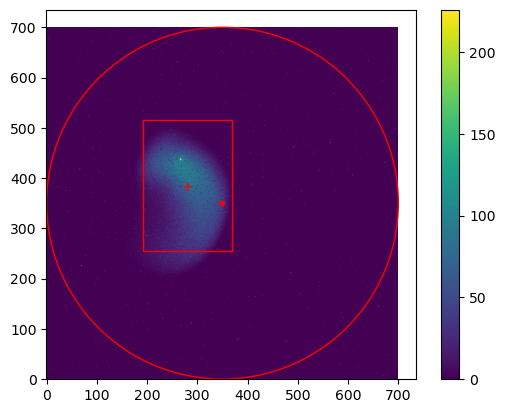

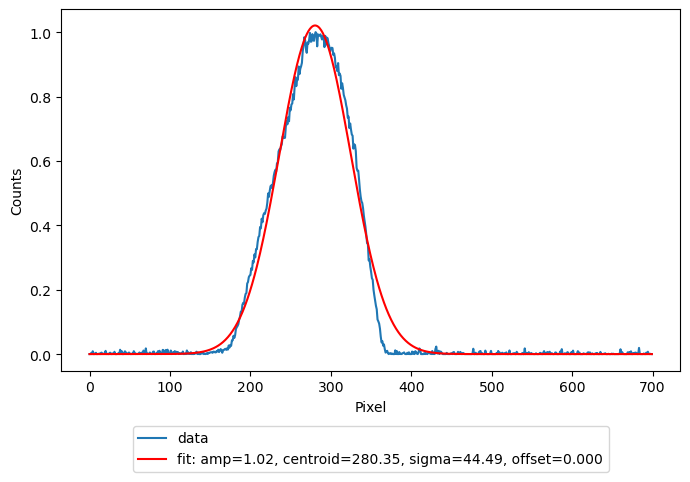

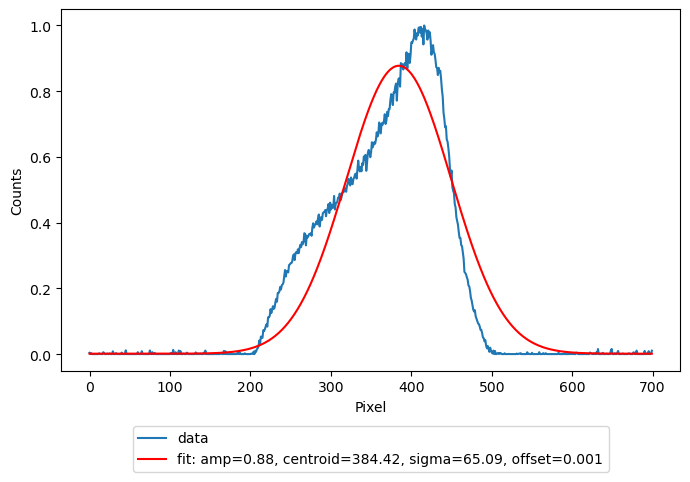

In [15]:
image_diagnostic.test_measurement()

In [16]:
optimizer.dump_file = "bax_run2"

In [17]:
optimizer.dump()